In [7]:
import ot
import torch
from data_gen_1D import Generator
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.offsetbox import AnchoredText

In [8]:
def wasserstein_distance(a, b, wa, wb):
        
    W_dist = ot.wasserstein_1d(a, b, wa, wb, p = 1)

    return W_dist

In [9]:
def Z_score(H0, t1):
    
    if t1 <= torch.max(H0):
        p_value = (torch.count_nonzero(H0 >= t1) + 1)/(torch.tensor(H0.size()) + 1)

    if t1 > torch.max(H0):
        p_value = 1/(torch.tensor(H0.size()) + 1)
        
    return torch.tensor(norm.ppf(1-p_value))

In [10]:
def Plotter(W_dist_calibration, W_dist, color, label, save):

    fig, ax = plt.subplots(1, 1, figsize = (7, 7))

    ax.set_title('Wasserstein distance', fontsize = 20)
    ax.set_xlabel('$W_{1}$', fontsize = 15)
    ax.set_ylabel('Density', fontsize = 15)

    z_score = Z_score(W_dist_calibration, torch.median(W_dist))
    anchored_text_test = AnchoredText('$Z_{score}$:'+str('%.3f' % z_score.item()), bbox_to_anchor = (1, 0.85), bbox_transform = ax.transAxes, loc = 'right')

    ax.hist(W_dist_calibration, bins = 'auto', color = color[0], density = True, label = 'ref-'+str(label[0]), alpha = 0.5)
    ax.hist(W_dist, bins = 'auto', color = color[1], density = True, label = 'ref-'+str(label[1]), alpha = 0.5)
    ax.legend()

    ax.add_artist(anchored_text_test)

    if save:

        fig.savefig(f'/home/gabrieleb/Colab_Marco/LPC_Plot/W_dist_{label}.pdf')



In [11]:
# data parameters
Pois_ON = False
N_R = 200000 # size of reference sample
"""
'ref': equivalent to background only
'NP1': peak in the tail
'NP2': non-resonant signal
'NP3': peak in the bulk
'NP4': a deficit in the tail
"""
sig_type = 'NP4'

NR = 2000 # size of background sample (for reference data - calibration - should be 2000)
NS = 0 # number of signal events (for reference data - calibration - should be zero)
ND = NR + NS # size of data sample (this sum should be 2000)

N = ND + N_R # total size
weight = ND/N_R

Computational time: 41.52204465866089


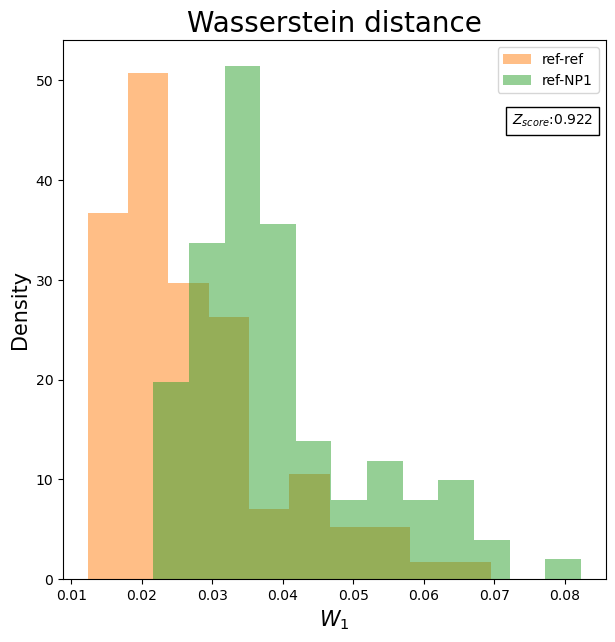

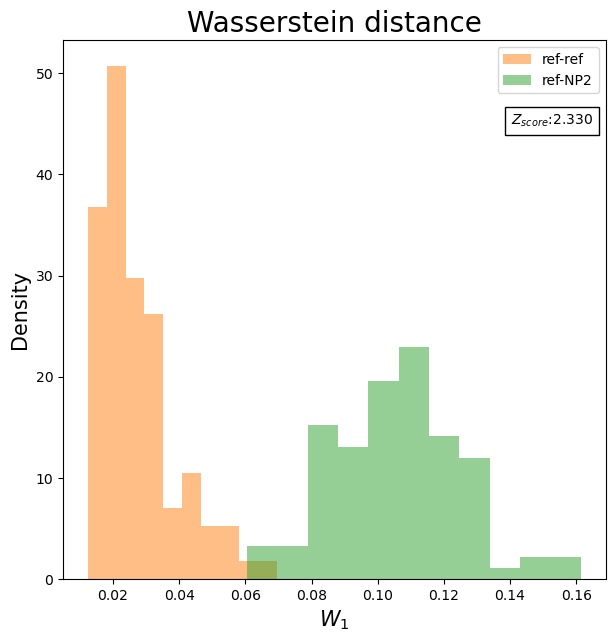

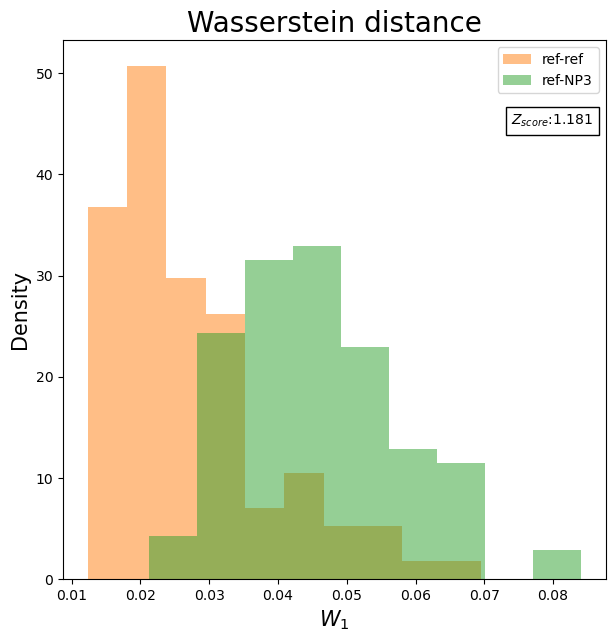

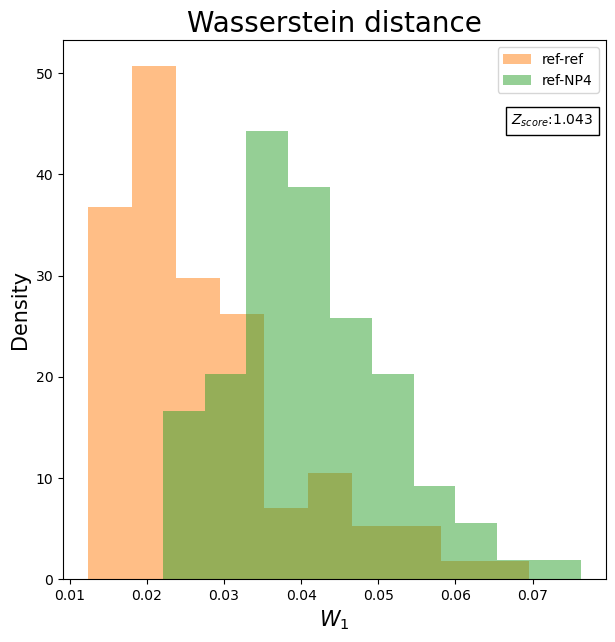

In [13]:
import time 
iteration = 100

W_dist_calibration = torch.zeros(iteration)
W_dist = torch.zeros(iteration)

classes = ['NP1', 'NP2', 'NP3', 'NP4']
values = [[10, 1990], [110, 1890], [80, 1920], [0, 2000]]

save = False

st = time.time()
l = 0

for sig_type in classes:
    
    for seed in range(iteration):

        #calibration
        ref, data = Generator(seed, NS, NR, N_R, 'ref', Pois_ON)
        W_dist_calibration[seed] = wasserstein_distance(torch.squeeze(ref), torch.squeeze(data), torch.tensor(1/ref.size(0)), torch.tensor(1/data.size(0)))

        #classes
        ref, data_true  = Generator(seed + int(1e6), values[l][0], values[l][1], N_R, sig_type, Pois_ON)
        W_dist[seed] = wasserstein_distance(torch.squeeze(ref), torch.squeeze(data_true), torch.tensor(1/ref.size(0)), torch.tensor(1/data_true.size(0)))
    
    Plotter(W_dist_calibration, W_dist, ['#ff7f0e', '#2ca02c'], ['ref', sig_type], save)
    l = l+1

et = time.time()

print(f'Computational time: {et-st}')